# Package installation

In [17]:
# %pip install xgboost
# %pip install lightgbm
# %pip install seaborn
# %pip install mlflow
# %pip install hyperopt

# Package Imports

In [18]:
import xgboost as xgb
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier
import seaborn as sns
#import mlflow
import pickle
import sys

In [19]:
import hyperopt
from hyperopt import hp, fmin,STATUS_OK,Trials
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from sklearn.model_selection import cross_val_score, train_test_split

In [20]:
df = pd.read_csv('Train.csv')
# used to target distribution
sample = df.copy()

# Problem Statement 
* We want to build a binary classifier to predict customer retention
* We evaluate our model performance using F1-score (hint for class imbalance)
* 1 represents customers who are inactive 0 represents active customers

# Exploratory Data Analysis
* we use EDA to formulate a hypothesis
* People who spend the most money and frequency the filling station are less likely to leave the network

In [21]:
df.head(10)

,ID,region,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,mrg,regularity,top_pack,freq_top_pack,Target
0,ID_YEB05X4KUGPQ,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
1,ID_Z9IQ9QH52KVN,Nebula,K > 24 month,4764.96,41.0,4756.84,1585.47,41.0,2.0,626.0,24.0,NaN,NaN,NaN,NO,62,On net 200F=Unlimited _call24H,31.0,0
2,ID_YZSU7B7M35QS,Celestial,K > 24 month,5769.23,22.0,5769.23,1923.08,22.0,28121.0,0.0,NaN,1.0,NaN,NaN,NO,61,NaN,NaN,0
3,ID_QS4F5LEX29KM,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,6,NaN,NaN,0
4,ID_8IYIC9PFU8U1,Eclipsara,K > 24 month,5341.88,58.0,5636.75,1879.06,60.0,1131.0,546.0,376.0,0.0,NaN,NaN,NO,62,Mixt 250F=Unlimited_call24H,31.0,0
5,ID_MJFIYBIBY0JO,Celestial,K > 24 month,42.74,1.0,42.74,14.10,2.0,4.0,3.0,NaN,NaN,NaN,NaN,NO,44,NaN,NaN,0
6,ID_LRE4OJMM1T2C,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,7,NaN,NaN,0
7,ID_BY33YU074XLI,Eclipsara,K > 24 month,2564.10,12.0,2777.78,926.07,13.0,NaN,96.0,96.0,1.0,NaN,NaN,NO,59,All-net 500F =2000F_AllNet_Unlimited,13.0,0
8,ID_GV22KJO949U2,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN,1
9,ID_8EP70ZC40LKW,Mandalore,K > 24 month,1987.18,13.0,2242.74,747.44,13.0,NaN,9.0,39.0,73.0,NaN,NaN,NO,34,All-net 500F=2000F;5d,8.0,0


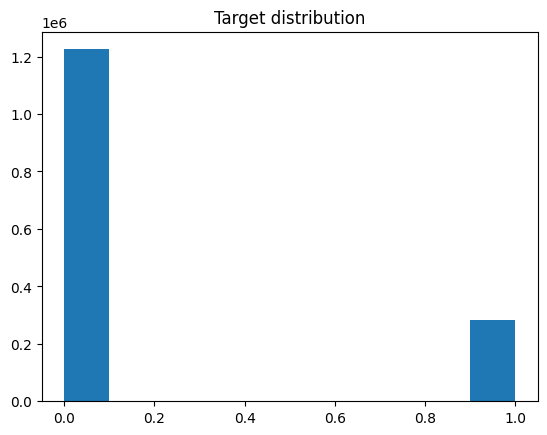

In [22]:
import matplotlib.pyplot as plt
plt.hist(df['Target'])
plt.title('Target distribution')
plt.show()

* we can observed from the target distribution that we have imbalanced data at approximaelty 1:4 in favour of class 0. 
* There are several techniques for dealing with imbalanced data such over or undersampling. 
* To get the classes to be on a comparable scale one would undersample the overrepresented class or over sample the underrepresented class.

# Analysis of numerical variables

In [23]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['missing count', 'missing percentage'])
    return missing_values

missing(df)

,missing count,missing percentage
zone2,1412329,93.666080
zone1,1388848,92.108813
Procuct_2,903050,59.890545
data_volume,741806,49.196795
freq_top_pack,631823,41.902690
top_pack,631823,41.902690
Procuct_1,626563,41.553845
region,594091,39.400292
on_net,550642,36.518741
Amount,529514,35.117526


* Zone1 and Zone2 have the most missing data

##  Dataset descriptive stats

In [24]:
numerical_columns = df.select_dtypes(include=np.number).columns
df[numerical_columns].describe()

,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,regularity,freq_top_pack,Target
count,978320.000000,978320.000000,999713.000000,999713.000000,999713.000000,7.660280e+05,957192.000000,881271.000000,604784.000000,118986.000000,95505.000000,1.507834e+06,876011.000000,1.507834e+06
mean,2361.212767,11.521423,2352.073152,784.027307,13.967657,3.354667e+03,278.000929,95.325088,23.146017,8.092187,7.465515,2.804414e+01,9.263913,1.873648e-01
std,3028.954909,13.266779,3053.176864,1017.723634,14.682316,1.330460e+04,874.412483,203.328016,63.506893,40.739423,32.145740,2.228078e+01,12.268658,3.902042e-01
min,4.270000,1.000000,0.430000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000e+00
25%,427.350000,2.000000,427.350000,142.310000,3.000000,0.000000e+00,5.000000,7.000000,2.000000,0.000000,0.000000,6.000000e+00,2.000000,0.000000e+00
50%,1282.050000,7.000000,1282.050000,427.350000,9.000000,2.560000e+02,27.000000,29.000000,6.000000,1.000000,2.000000,2.400000e+01,5.000000,0.000000e+00
75%,3141.030000,16.000000,3146.580000,1048.720000,20.000000,2.879000e+03,156.000000,99.000000,20.000000,3.000000,5.000000,5.100000e+01,12.000000,0.000000e+00
max,124145.300000,133.000000,113696.580000,37898.720000,91.000000,1.823866e+06,50809.000000,12040.000000,4174.000000,4792.000000,3143.000000,6.200000e+01,629.000000,1.000000e+00


## Multicollinerity of numerical features

* We use the correlation matrix to visualise the relationship between features and target variable
* collinear features should be removed since they can hinder model performance and are also redundant

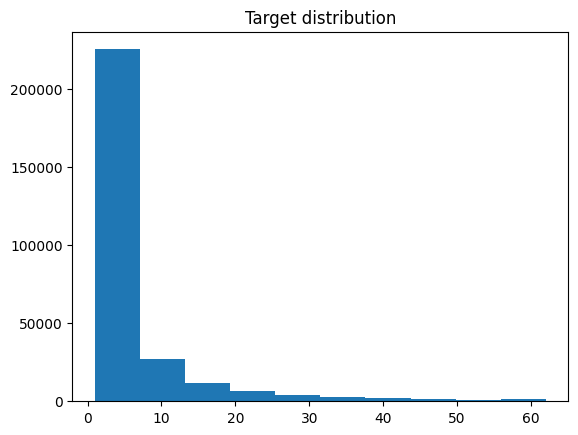

In [25]:
plt.hist(df[df['Target']==1]['regularity'])
plt.title('Target distribution')
plt.show()

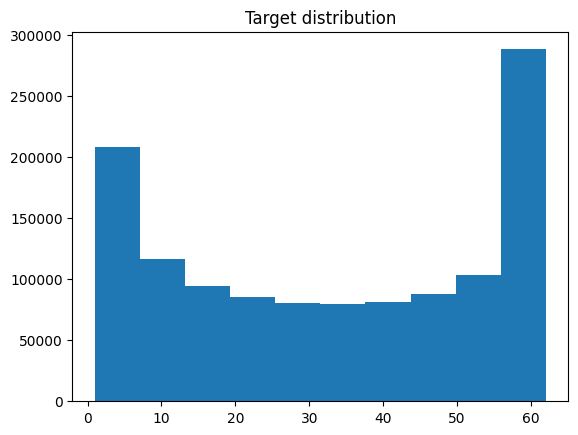

In [26]:
plt.hist(df[df['Target']==0]['regularity'])
plt.title('Target distribution')
plt.show()

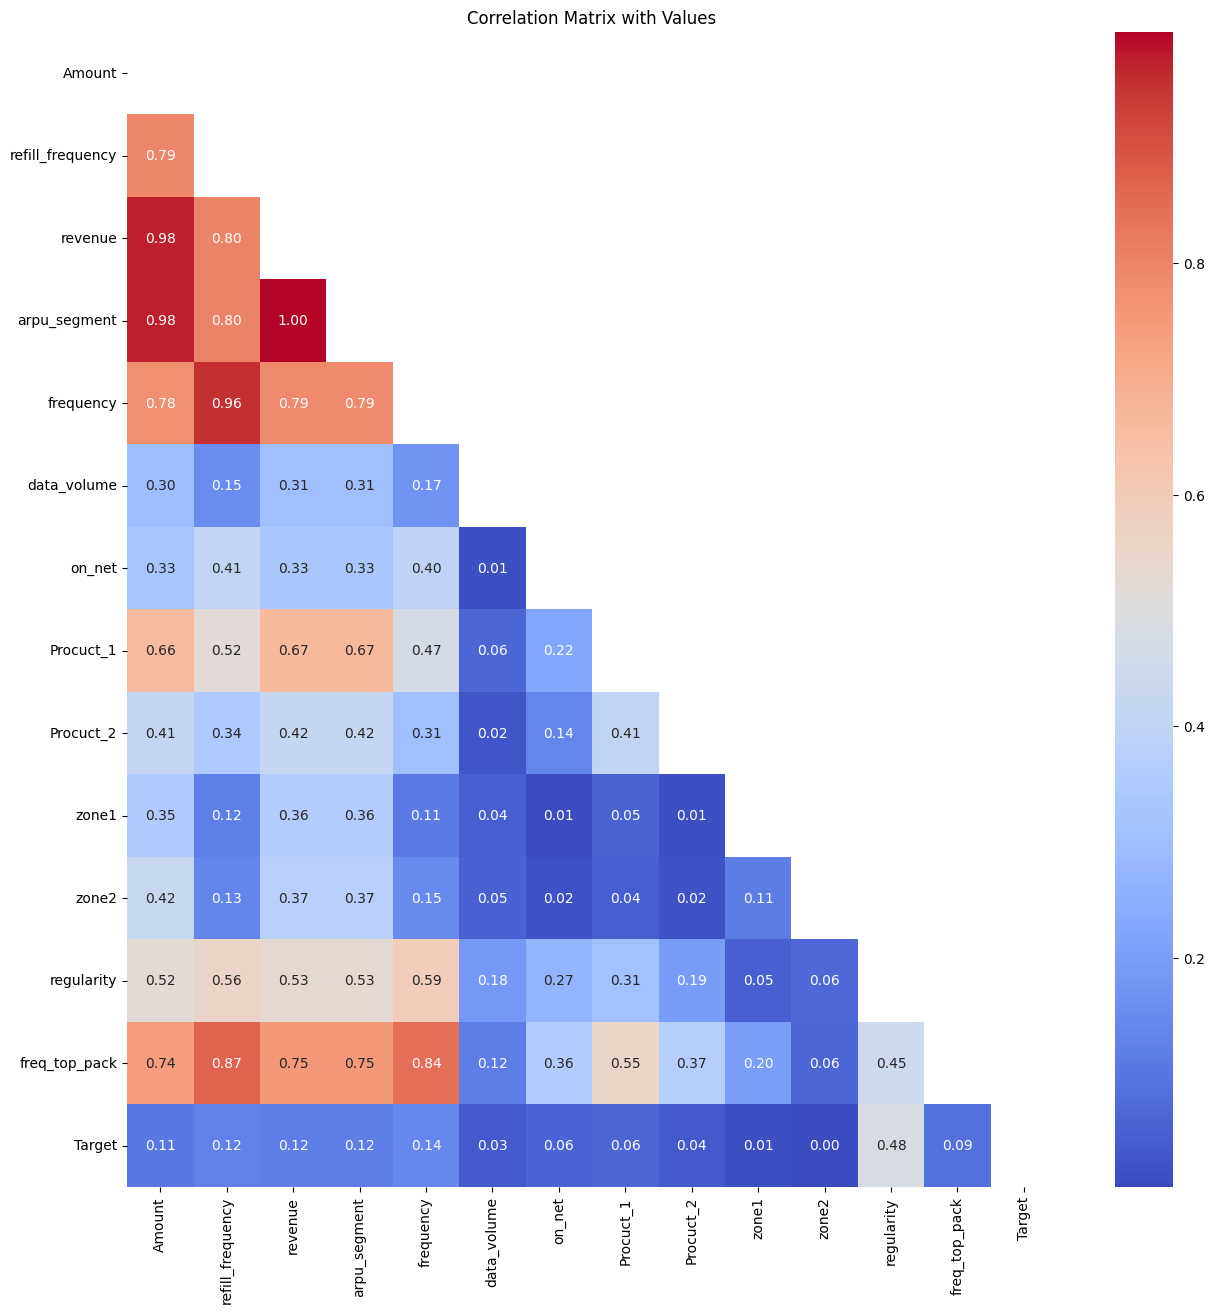

In [27]:
correlation_matrix = df[numerical_columns].corr()
sorted_corr_matrix = correlation_matrix.abs()
sorted_corr_matrix = sorted_corr_matrix[sorted_corr_matrix.columns]
# Plot the correlation matrix
mask = np.triu(np.ones_like(sorted_corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(15, 15))

# Draw the heatmap with values
sns.heatmap(sorted_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)

# Set labels and titleß
plt.title('Correlation Matrix with Values')
plt.show()

In [28]:
#takes a lot of time to run
#sns.pairplot(df[numerical_columns])

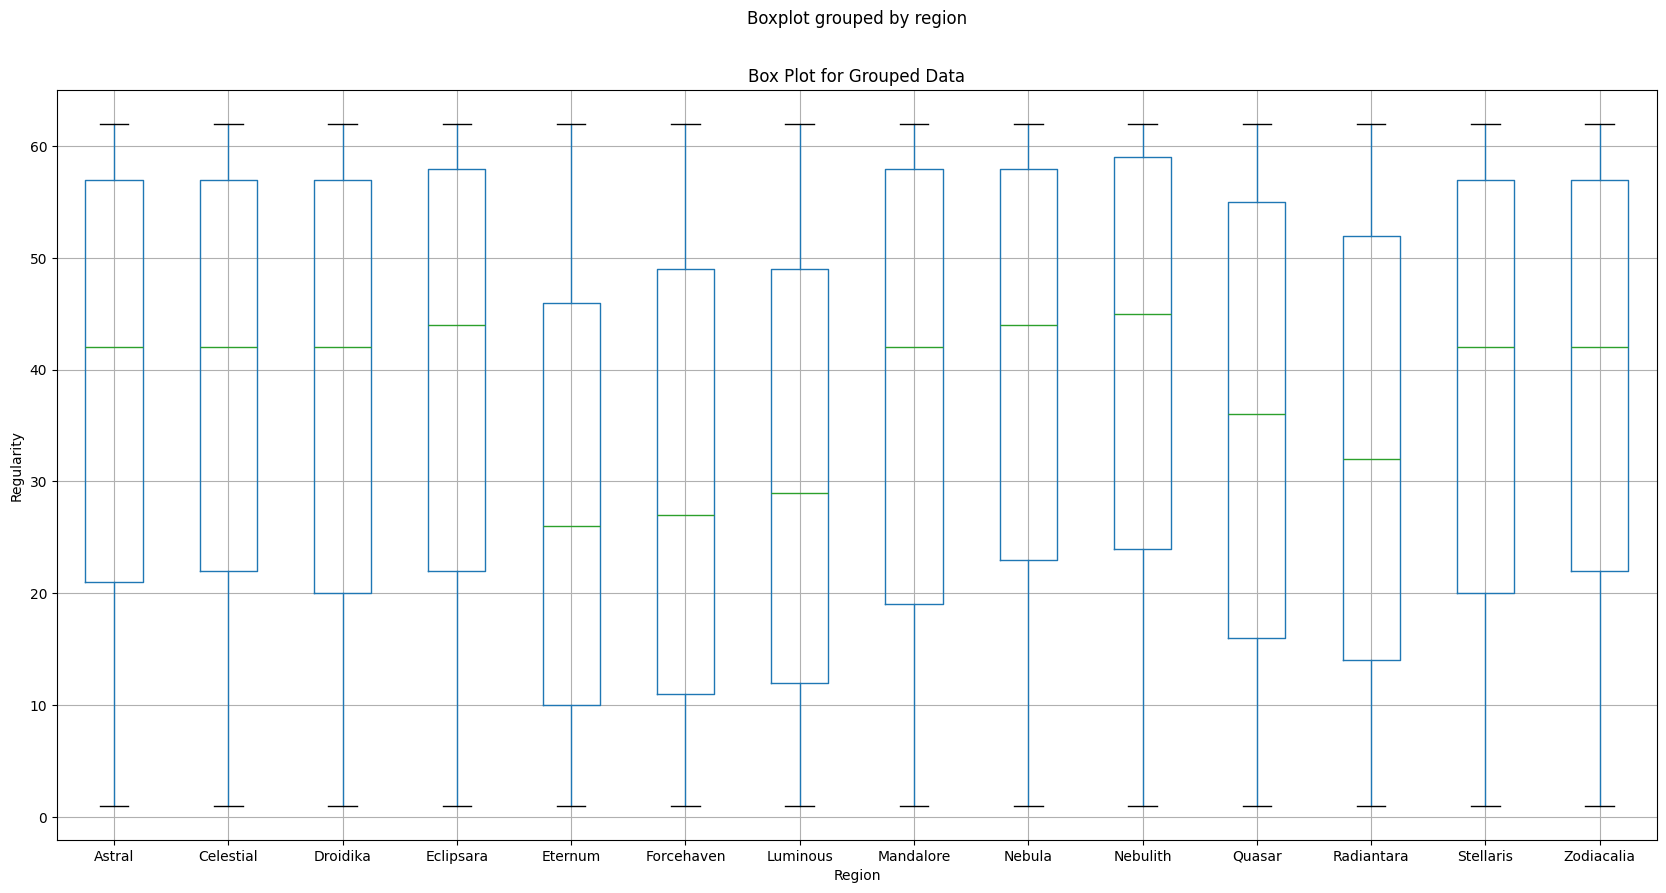

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))
df.boxplot(by='region', column='regularity', ax=ax)
# Set labels and title
plt.xlabel('Region')
plt.ylabel('Regularity')
plt.title('Box Plot for Grouped Data')

# Show the plot
plt.show()

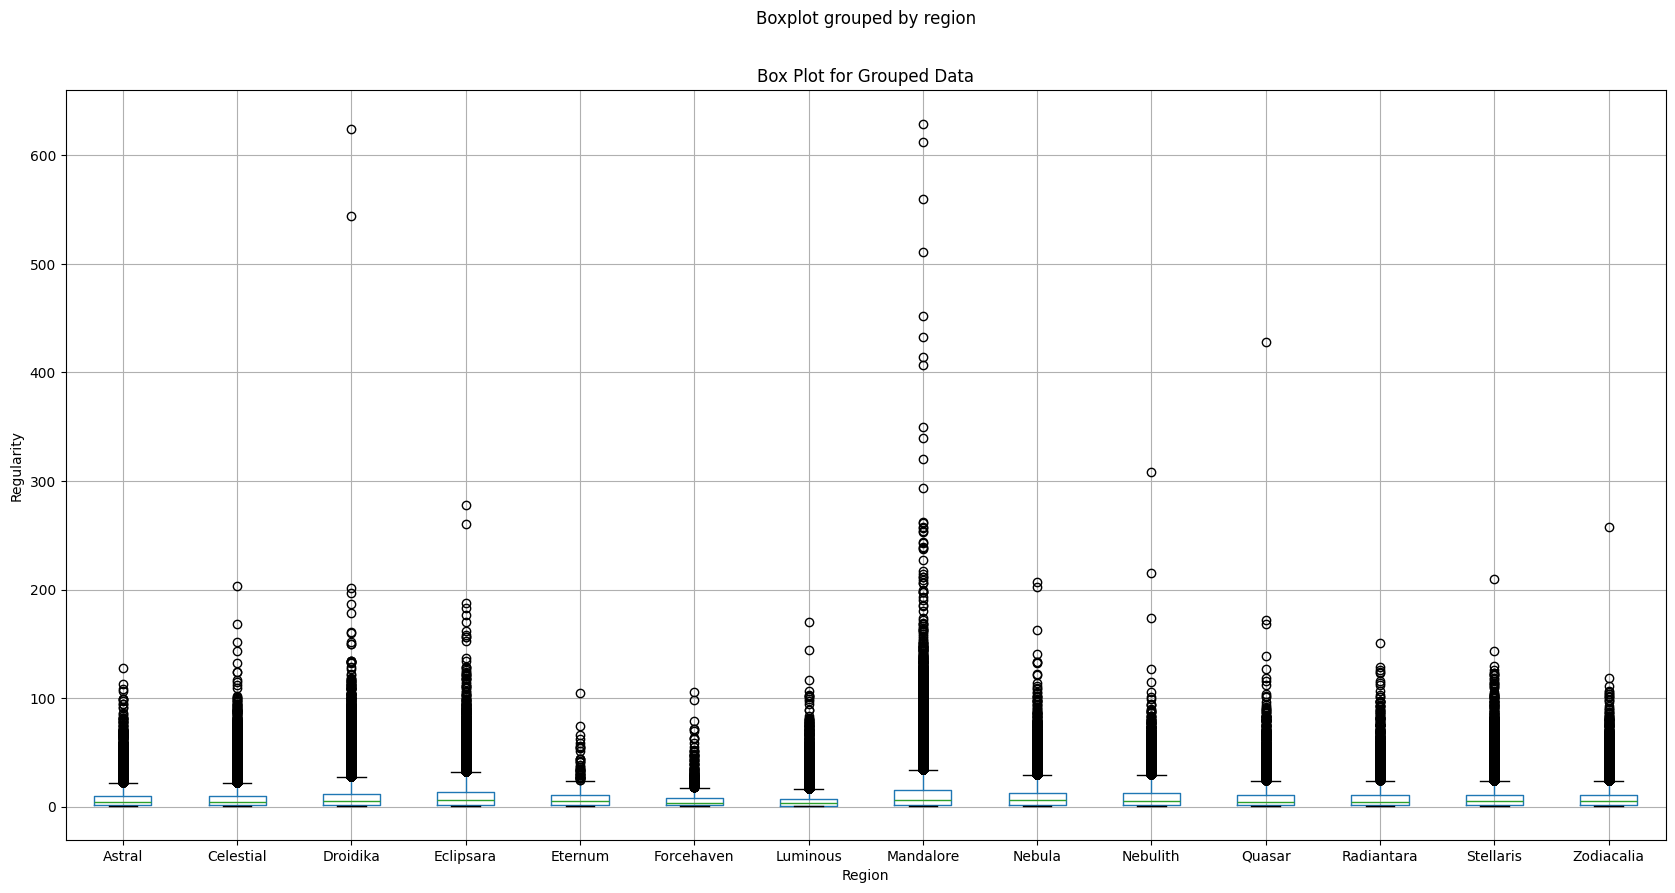

In [30]:
fig, ax = plt.subplots(figsize=(20, 10))
df.boxplot(by='region', column='freq_top_pack', ax=ax)
# Set labels and title
plt.xlabel('Region')
plt.ylabel('Regularity')
plt.title('Box Plot for Grouped Data')

# Show the plot
plt.show()

## Categorical features

* We evaluate the cardinality of the categorical data
* top_pack has the most unique values with mrg having the least (1). 
* Based on the cardinality we can drop mrg in our analysis due to in not affecting the predictive power of the model.

In [31]:
categorical = df.select_dtypes(exclude='number').columns
df[categorical].nunique()
df[categorical] = df[categorical].astype('category')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507834 entries, 0 to 1507833
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   ID                1507834 non-null  category
 1   region            913743 non-null   category
 2   tenure            1507834 non-null  category
 3   Amount            978320 non-null   float64 
 4   refill_frequency  978320 non-null   float64 
 5   revenue           999713 non-null   float64 
 6   arpu_segment      999713 non-null   float64 
 7   frequency         999713 non-null   float64 
 8   data_volume       766028 non-null   float64 
 9   on_net            957192 non-null   float64 
 10  Procuct_1         881271 non-null   float64 
 11  Procuct_2         604784 non-null   float64 
 12  zone1             118986 non-null   float64 
 13  zone2             95505 non-null    float64 
 14  mrg               1507834 non-null  category
 15  regularity        1507834 non-nu

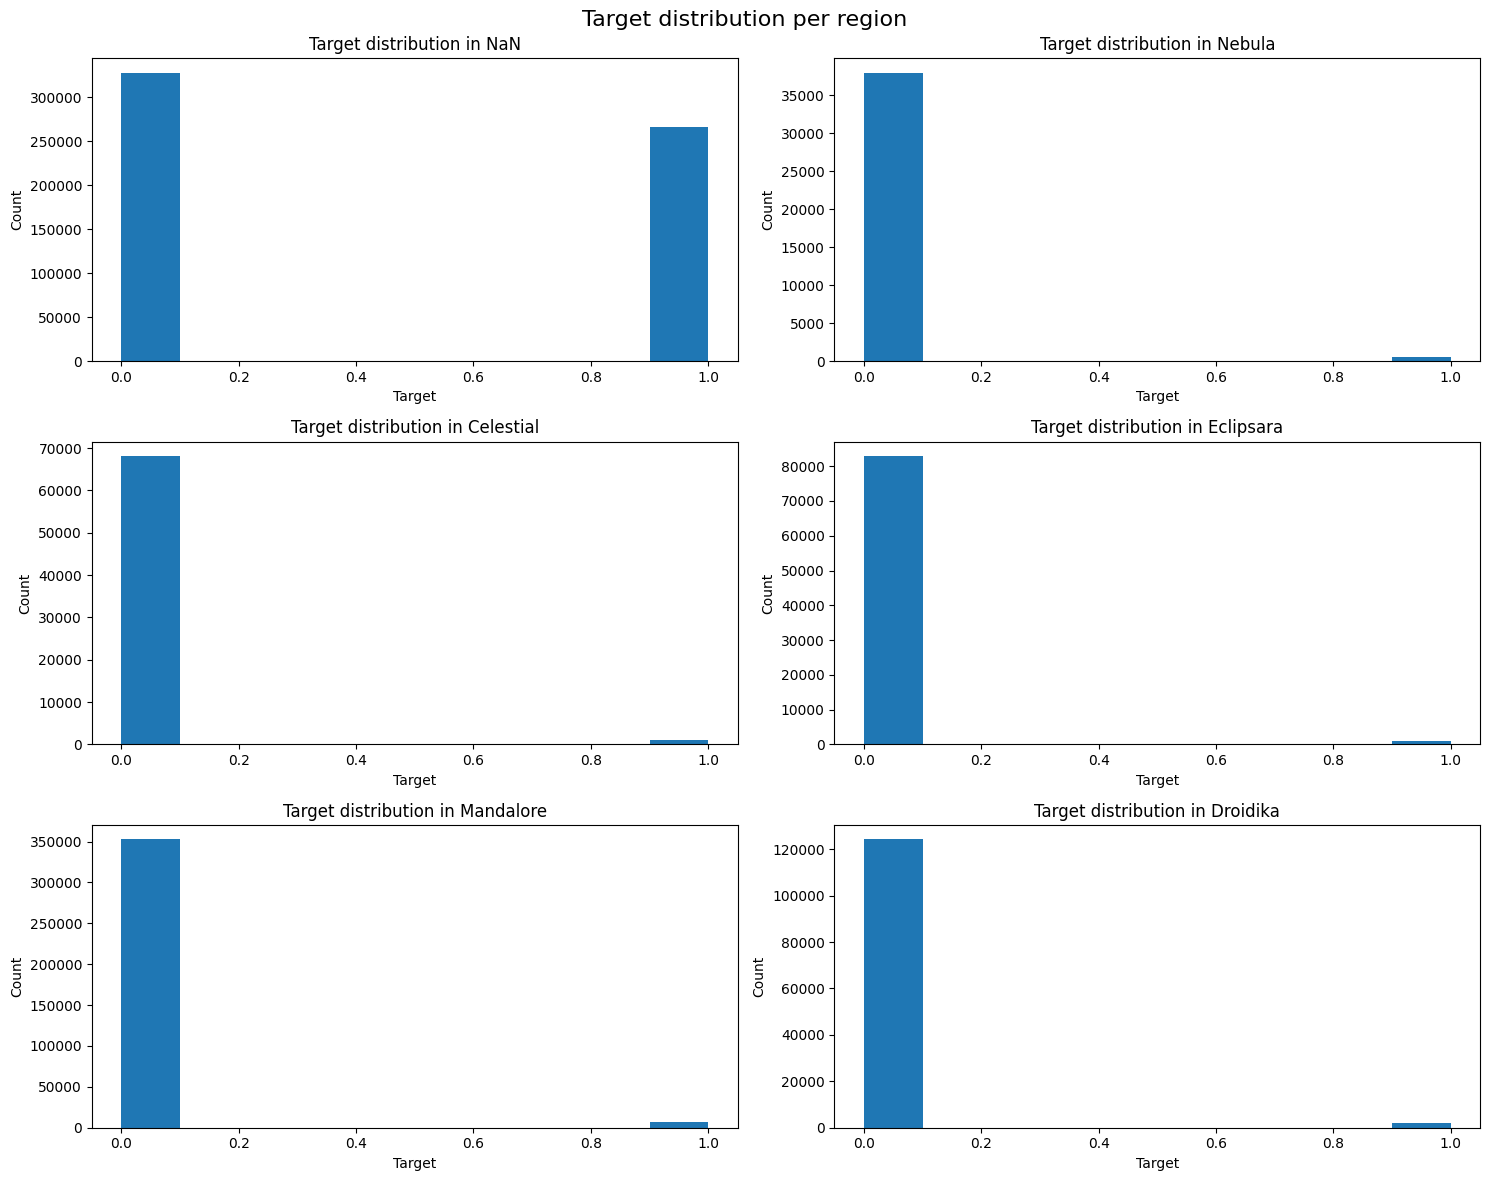

In [33]:
sample['region'].fillna('NaN',inplace=True) # this is needed to calculate distribution for missing data
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
fig.suptitle("Target distribution per region", fontsize=16)
plt.subplots_adjust(hspace=3)

for region, ax in zip(sample['region'].unique(), axs.ravel()):
    ax.hist(sample[sample['region']==region]['Target'])
    ax.set_title(f'Target distribution in {region}')
    ax.set_xlabel('Target')
    ax.set_ylabel('Count')
plt.tight_layout()

* We can see that the target distribution is the same in all regions 
* It then follows that the missing data will be distributed among the regions in a manner that maintains the distribution.

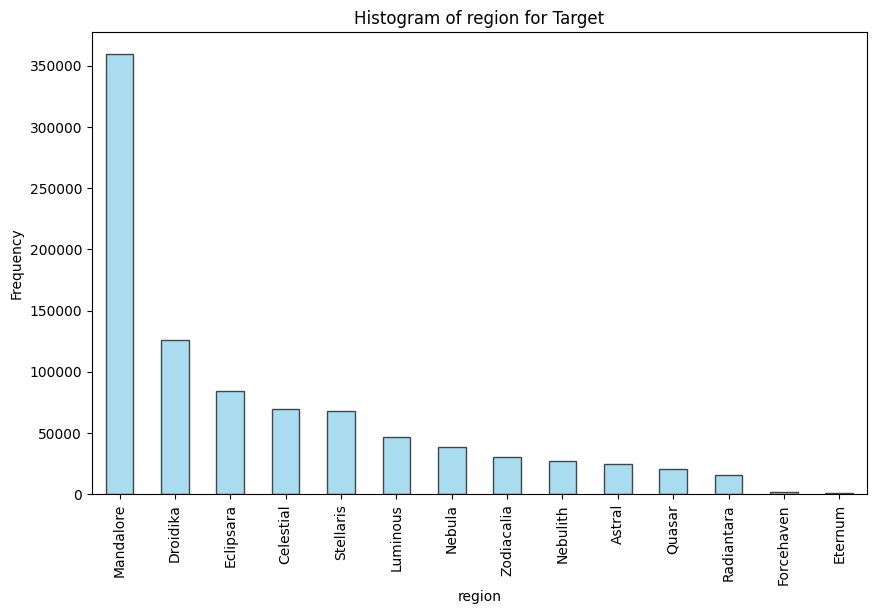

In [34]:
category_counts = df['region'].value_counts()
categorical_column = 'region'
target_column =  'Target'
# Plot histogram
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.7)
plt.title(f'Histogram of {categorical_column} for {target_column}')
plt.xlabel(categorical_column)
plt.ylabel('Frequency')
plt.show()

# Analysis of underrepresented class

Below we get the count of missing data in the underrepresented class. We should only consider oversampling if our data is "clean". Oversampling noisy data will only hurt model performance.

In [35]:
# missing values
positive_subset = df[df['Target'] == 1]
missing(positive_subset)

,missing count,missing percentage
zone2,277434,98.201511
zone1,277145,98.099216
region,266137,94.202786
Procuct_2,263999,93.446012
freq_top_pack,247319,87.541900
top_pack,247319,87.541900
Procuct_1,246962,87.415535
Amount,233555,82.669947
refill_frequency,233555,82.669947
on_net,232906,82.440224


In [36]:
# check duplicated data
df.duplicated().sum()

0

Cardinality of categorical data.

In [37]:
percentage_threshold = 50
# Calculate the maximum number of missing values allowed for each row
max_missing_values = (percentage_threshold / 100) * positive_subset.shape[1]
# Count the number of rows with missing values exceeding the threshold
rows_above_threshold = positive_subset[positive_subset.isnull().sum(axis=1) > max_missing_values].shape[0]
print(rows_above_threshold/len(positive_subset)*100)

83.68405217422084


* 83% of the rows in the underrepresented class have more than half of the features missing which is not good if we want to oversample

# Feature Engineering

In [38]:
def clean_string_column(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: x.replace(' ', ''))
    # some instances have On-net other have on net
    df[column_name] = df[column_name].apply(lambda x: x.replace('-', ''))
    df[column_name] = df[column_name].apply(lambda x: x.replace(';', ','))
    df[column_name] = df[column_name].str.lower()
    return df

def engineer_features(df):
    # concatenation of the region and top_pack feature
    df["top_pack_region_concat"] = df['region'].astype(str)+df['top_pack'].astype(str)
    # average revenue spent per visit by a customer
    df["revenue_per_visit"] = 3*df['arpu_segment']/df['regularity']
    # a limited view of revenue per visit (looking at 90 day window)
    df["freq_regularity"] = df['frequency']*df['regularity']
    # calls in network belonging to by product1 (feature product for correctness )
    df["on_net_in_procuct"] = df['on_net']*df['Procuct_1']
    # ratio of revenue generated by top_pack (inverse for correctness)
    df["frequency_balance"] = df['freq_top_pack']/df['frequency']

    # format features
    df['top_pack'] = df['top_pack'].astype('category')
    df['top_pack_region_concat'] = df['top_pack_region_concat'].astype('category')
    return df

In [39]:
df['top_pack'] = df['top_pack'].astype('category')
df = clean_string_column(df, 'top_pack')
df = engineer_features(df)

# Modelling

In [40]:
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.metrics import f1_score, precision_recall_curve,classification_report

* drop highly correlated features features 
* drop feature not correlated with target variable 

In [41]:
X = df.drop(columns=['Target','ID','mrg','tenure','zone1','zone2'])
y = df['Target']

# n-/p+ sample ratio proportion. Equation is given XGBoost and LGBM documentation (scale_pos_weight)
ratio = float(y.value_counts()[0]/y.value_counts()[1])
X_train, X_test, y_train, y_test= train_test_split(X, y,stratify=y,test_size=0.20,random_state=420)
print(ratio)

4.337182096525848


* This means for every single customer that churns 4 stay 

In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507834 entries, 0 to 1507833
Data columns (total 18 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   region                  913743 non-null   category
 1   Amount                  978320 non-null   float64 
 2   refill_frequency        978320 non-null   float64 
 3   revenue                 999713 non-null   float64 
 4   arpu_segment            999713 non-null   float64 
 5   frequency               999713 non-null   float64 
 6   data_volume             766028 non-null   float64 
 7   on_net                  957192 non-null   float64 
 8   Procuct_1               881271 non-null   float64 
 9   Procuct_2               604784 non-null   float64 
 10  regularity              1507834 non-null  int64   
 11  top_pack                876011 non-null   category
 12  freq_top_pack           876011 non-null   float64 
 13  top_pack_region_concat  1507834 non-null  

In [43]:
def threshold_calibration(model,X,y):
    probabilities = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, probabilities)
    # Calculate F1 score for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall)
    # Find the threshold that maximizes F1 score
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    # Convert probabilities to binary predictions based on the threshold
    predictions = (probabilities > optimal_threshold).astype(int)
    return predictions, optimal_threshold

# Hyperparameter Tuning

In [44]:
#get experiment in MlFlow
def get_or_create_experiment_id(name):
    exp = mlflow.get_experiment_by_name(name)
    if exp is None:
      exp_id = mlflow.create_experiment(name)
      return exp_id
    return exp.experiment_id

# run local server
server_uri = 'http://127.0.0.1:5000'
mlflow.set_tracking_uri(server_uri)

## XG Boost Model

In [45]:
# experiment_name = "XG Boost tuning"
xgb_exp_id = get_or_create_experiment_id(experiment_name)
print(xgb_exp_id)

In [46]:
parameter_space = {
        "objective":'binary:logistic',
        "n_estimators": hp.uniformint('n_estimators',600,800),
        "scale_pos_weight" : hp.uniform('scale_pos_weight',ratio-2,ratio+2),
        "min_child_weight" : hp.uniform('min_child_weight',0.1,3),
        "max_depth" : hp.uniformint('max_depth',1,20),
        "gamma": hp.uniform('gamma',1,10),
        "lambda": hp.uniform('lambda',1,2),
        "colsample_bytree" : hp.uniform('colsample_bytree',0.1,0.8),
        "eta": hp.uniform('eta',0.001,0.1),
        "enable_categorical":True,
        "tree_method":"hist",
        "random_state": hp.uniformint('random_state',0,420,)
         }

def objective(s_space):
    model=xgb.XGBClassifier(**s_space)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    f1_score = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
    mean_f1= mean(f1_score)
    print('evaluated f1_score={}'.format(mean_f1), file=sys.stdout)
    return {'loss': -mean_f1, 'status': STATUS_OK}

trials = Trials()

In [47]:
with mlflow.start_run(experiment_id=xgb_exp_id) as run:
    best = fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.tpe.suggest,
        max_evals=10,
        rstate=np.random.default_rng(420)
        )
    hyper_params = best.copy()
    hyper_params['n_estimators'] = int(hyper_params['n_estimators'])
    hyper_params['max_depth'] = int(hyper_params['max_depth'])
    hyper_params['random_state'] = int(hyper_params['random_state'])

    print(hyper_params)

    xgb_model = xgb.XGBClassifier(enable_categorical=True,**hyper_params)
    xgb_model.fit(X_train,y_train)
    target_names = ['1','0']
    binary_predictions,optimal_threshold = threshold_calibration(xgb_model,X_test,y_test)

    report = classification_report(y_test, binary_predictions, target_names=target_names,output_dict=True)
    f1_optiminal=f1_score(y_test, binary_predictions)
    print(report)
    plot_importance(xgb_model)
    pyplot.show()

    #Ml flow logging
    mlflow.log_dict(report,"classification_report.json")
    mlflow.log_metric("threshold",optimal_threshold)
    mlflow.log_metric("f1-score",f1_optiminal)
    mlflow.log_dict(hyper_params,"hyperparameters.json")
    mlflow.sklearn.log_model(xgb_model, artifact_path="xg_classifier")

## LGBM Model

In [48]:
light_param = {
        "n_estimators": hp.uniformint('n_estimators',700,1000),
        'bagging_fraction':hp.uniform('bagging_fraction',0.3,1),
        "num_leaves" : hp.uniformint('num_leaves',10,50),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
        "subsample" :  hp.uniform('subsample',0.1,0.9),
        "scale_pos_weight" : hp.uniform('scale_pos_weight',2,6),
        "learning_rate": hp.uniform('learning_rate',0.001,0.2),
        "max_depth" : hp.uniformint('max_depth',4,30),
        "max_delta_step": hp.uniform('max_delta_step',0,1),
        "lambda_l1": hp.uniform('lambda_l1',1,10),
        "lambda_l2": hp.uniform('lambda_l2',1,10),
        "data_sample_strategy": "goss",
        "random_state": hp.uniformint('random_state',0,420,)
         }

def objective(light_param):
    model=lgb.LGBMClassifier(**light_param,verbose=-1)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    f1_score = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
    mean_f1= mean(f1_score)
    print('evaluated f1_score={}'.format(mean_f1), file=sys.stdout)
    return {'loss': -mean_f1, 'status': STATUS_OK}

trials = Trials()

In [49]:
#experiment_name = "LGBM tuning"
lgbm_exp_id = get_or_create_experiment_id(experiment_name)
print(lgbm_exp_id)

In [50]:
with mlflow.start_run(experiment_id=lgbm_exp_id) as run:
    best = fmin(
        fn=objective,
        space=light_param,
        algo=hyperopt.tpe.suggest,
        max_evals=2,
        rstate=np.random.default_rng(420)
        )
    light_hyper_params = best.copy()
    light_hyper_params['n_estimators']=int(light_hyper_params['n_estimators'])
    light_hyper_params['num_leaves']=int(light_hyper_params['num_leaves'])
    light_hyper_params['max_depth']=int(light_hyper_params['max_depth'])
    light_hyper_params['random_state'] = int(light_hyper_params['random_state'])
    print(light_hyper_params)

    lgbm_model=lgb.LGBMClassifier(**light_hyper_params)
    lgbm_model.fit(X_train,y_train)
    target_names = ['1','0']
    binary_predictions,optimal_threshold = threshold_calibration(lgbm_model,X_test,y_test)
    report = classification_report(y_test, binary_predictions, target_names=target_names,output_dict=True)

    f1_optiminal=f1_score(y_test, binary_predictions)
    print(report)
    lgb.plot_importance(lgbm_model, importance_type="auto", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
    plt.show()
    mlflow.log_dict(report,"classification_report.json")
    mlflow.log_metric("threshold",optimal_threshold)
    mlflow.log_metric("f1-score",f1_optiminal)
    mlflow.log_dict(light_hyper_params,"hyperparameters.json")
    mlflow.sklearn.log_model(lgbm_model, artifact_path="LGBM_classifier")

# Stack models

[Model stacking](http://cs.ndsu.edu/~siludwig/Publish/papers/JDEDA2019.pdf)

In [51]:
# Best parameters as determined through tuning

hyper_params = {
  "colsample_bytree": 0.5963716402007907,
  "eta": 0.07789478286985815,
  "gamma": 7.766033753477361,
  "lambda": 1.5786093020474634,
  "max_depth": 15,
  "min_child_weight": 1.0049588661143625,
  "n_estimators": 676,
  "random_state": 211,
  "scale_pos_weight": 2.6175814801157236
}

light_hyper_params = {
  "bagging_fraction": 0.44972209153930615,
  "colsample_bytree": 0.16363099220645919,
  "lambda_l1": 4.927461839631854,
  "lambda_l2": 6.484487318127595,
  "learning_rate": 0.1772076703106848,
  "max_delta_step": 0.17495268417023835,
  "max_depth": 23,
  "n_estimators": 775,
  "num_leaves": 31,
  "random_state": 37,
  "scale_pos_weight": 2.4151293819333555,
  "subsample": 0.3640283661743905
}

In [ ]:
%%time

# estimators generate level-one data
estimators = [
      ('lgbm', lgb.LGBMClassifier(**light_hyper_params,verbose=-1)),
     ('xg', xgb.XGBClassifier(enable_categorical=True,**hyper_params)),
     ('lgbm2', lgb.LGBMClassifier(**light_hyper_params,verbose=-1))
]

# no cross validation as it is already in base estimators
# 2 separate datasets should be used to avoid data leakage between base learners and meta learner.
# Through experimentation using a 2 datasets did not result in any significant improvements. So one dataset sufficed.

clf_stacked = StackingClassifier(estimators=estimators, final_estimator=xgb.XGBClassifier(enable_categorical=True,**hyper_params))
clf_stacked.fit(X_train, y_train)

In [ ]:
# save model
with open('stack.pkl', 'wb') as file:
    pickle.dump(clf_stacked, file)

Before threshold calibration

In [ ]:

clf_y_pred = clf_stacked.predict(X_test)
clf_y_pred_proba = clf_stacked.predict_proba(X_test)[:, 1]
target_names = ['1','0']
print(classification_report(y_test, clf_y_pred, target_names=target_names))

f1_stacked=f1_score(y_test, clf_y_pred)
print(f1_stacked)

              precision    recall  f1-score   support

           1       0.97      0.85      0.91    245064
           0       0.57      0.87      0.69     56503

    accuracy                           0.85    301567
   macro avg       0.77      0.86      0.80    301567
weighted avg       0.89      0.85      0.87    301567

0.6920851662854126


After threshold calibration

In [ ]:
binary_predictions,optimal_threshold = threshold_calibration(clf_stacked,X_test,y_test)
report = classification_report(y_test, binary_predictions, target_names=target_names)
print(report)
print(optimal_threshold)

              precision    recall  f1-score   support

           1       0.95      0.88      0.92    245064
           0       0.61      0.81      0.70     56503

    accuracy                           0.87    301567
   macro avg       0.78      0.85      0.81    301567
weighted avg       0.89      0.87      0.87    301567

0.57667375


# Precision Recall Curve

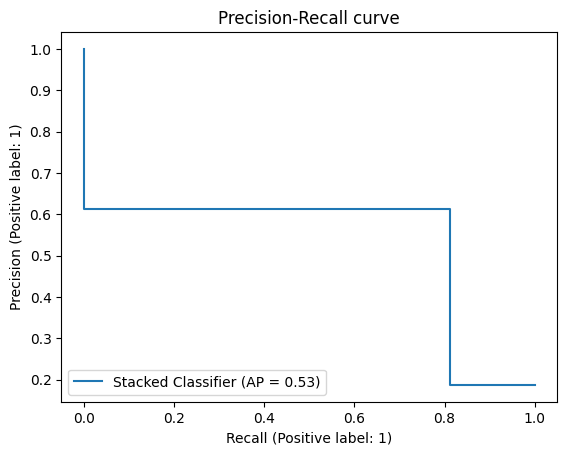

In [ ]:
display = PrecisionRecallDisplay.from_predictions(y_test, binary_predictions, name="Stacked Classifier")
_ = display.ax_.set_title("Precision-Recall curve")

# Inference

In [ ]:
submit= pd.read_csv('Test.csv')
non_numeric_columns = submit.select_dtypes(exclude='number').columns.tolist()
submit[non_numeric_columns] = submit[non_numeric_columns].astype('category')
submit = clean_string_column(submit, 'top_pack')
submit = engineer_features(submit)
ID = submit['ID']
submit.drop(columns=['ID','mrg','tenure','zone1','zone2'],inplace=True)

In [ ]:
%%time
with open('stack.pkl', 'rb') as file:
    # load model
    stacked_clf = pickle.load(file)
    probabilities = stacked_clf.predict_proba(submit)

    # determined through threshold calibration
    optimal_threshold = 0.57706314

    # Convert probabilities to binary predictions based on the threshold
    binary_predictions = (probabilities > optimal_threshold).astype(int)[:, 1]
    fin_df = pd.DataFrame(binary_predictions, columns = ['Target'])
    fin_df["ID"] =ID
    fin_df[fin_df.columns[::-1]].to_csv("churn_classification2.csv",index = False)

CPU times: user 40.4 s, sys: 1.45 s, total: 41.9 s
Wall time: 4.82 s


In [ ]:
# Prediction distribution
pred_dist = float(fin_df['Target'].value_counts()[0]/fin_df['Target'].value_counts()[1])
print(pred_dist)

3.02804916816785
